# Bước 1: Import Modules

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from io import BytesIO
import pandas as pd
import numpy as np
import requests
np.random.seed(0)
plt.style.use("ggplot")
import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.7.0
GPU detected: []


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Bước 2: Load bộ dữ liệu NER

Thông tin các thực thể:

geo = Geographical Entity\
org = Organization\
per = Person\
gpe = Geopolitical Entity\
tim = Time indicator\
art = Artifact\
eve = Event\
nat = Natural Phenomenon

Sau khi đọc tập dữ liệu, chúng ta quan sát thử 50 dòng đầu tiên như thế nào.


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Download(Win11)/ner_dataset.csv',encoding="latin1")
data = data.fillna(method="ffill")
data.head(50)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


Thông kê bộ dữ liệu:
- Số lượng từ duy nhất trong kho ngữ liệu.
- Số lượng thẻ duy nhất trong tập dữ liệu.\
Bằng cách sử dụng hàm **“nunique”.**

In [ ]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


Tạo một danh sách và sử dụng phương thức set() để lấy các giá trị trong cột “word” và loại bỏ giá trị trùng.\
Thêm phần đệm có tên “Endpad”.


In [ ]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [ ]:
print(words)
print(num_words)

['integration', 'rocket-propelled', 'Miltzow', 'Ataturk', 'Bart', 'Susy', '2.35', 'stir', '275-members', 'Cy', 'pleasant', 'environment-themed', 'Tracy', '131-5', 'derailment', 'five-time', 'air-dropping', 'renounces', 'theory', 'send', 'al-Muhajer', 'downsized', 'playlists', 'Hudur', 'ugly', 'revolution', 'daylight', 'sedated', 'Rubaie', 'airplanes', 'disparage', 'two-week-old', 'Lieutenant-Colonel', 'Sadiq', 'coups', 'Midwest', 'Caribbean', 'distraction', 'Kazemi', 'Improvised', '150-meter-long', '1854', 'graveyards', 'Rabdhure', 'liberate', 'Apr-46', 'standardized', 'pro-Tibetan', 'remittance', 'Mbeki', 'euro-zone', 'plead', 'Soonthorn', 'redenomination', 'Kember', 'Hafsa', 'arrangements', 'Vigorous', 'extraditing', 'specialty', 'Mosleshi', 'skidded', 'Amani', 'requital', 'overborrowing', 'raiser', 'enjoy', 'al-Haiman', 'Anjem', 'smoke', 'fondles', 'Wuhan', 'granddaughter', 'OIC', 'Whom', 'Leading', 'readies', 'strengthened', 'Qala', 'abide', 'Canadian-born', 'deploring', 'Jabber', 

In [ ]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)

In [ ]:
print(tags)
print(num_tags)

['I-per', 'I-eve', 'I-org', 'I-tim', 'B-per', 'I-art', 'I-geo', 'I-nat', 'B-gpe', 'B-tim', 'B-art', 'B-geo', 'B-eve', 'I-gpe', 'B-nat', 'O', 'B-org']
17


In [ ]:
print(num_words, num_tags)

35179 17


# Bước 3: Lấy các câu và các thẻ tương ứng

In [ ]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [ ]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [ ]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

# Bước 4: Ánh xạ giữa các câu và chỉ mục
Chúng ta có thể thấy rằng mỗi từ được gán cho một thẻ duy nhất. Chúng tôi có thể truy xuất những từ này bằng cách sử dụng các chỉ số của chúng và tra cứu chúng trong từ điển và trả về các khóa tương ứng.


In [ ]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [ ]:
# word2idx
tag2idx 

{'B-art': 10,
 'B-eve': 12,
 'B-geo': 11,
 'B-gpe': 8,
 'B-nat': 14,
 'B-org': 16,
 'B-per': 4,
 'B-tim': 9,
 'I-art': 5,
 'I-eve': 1,
 'I-geo': 6,
 'I-gpe': 13,
 'I-nat': 7,
 'I-org': 2,
 'I-per': 0,
 'I-tim': 3,
 'O': 15}

Bước 5: Padding  đầu vào and cắt dữ liệu thành tập Train/Test\
Độ dài của câu trong tập dữ liệu khoảng 20 đến 22 dấu từ. Và trong trục X, có thể thấy giá trị an toàn là khoảng 50.

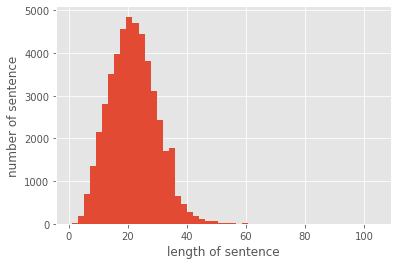

In [ ]:
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel("length of sentence")
plt.ylabel('number of sentence')
plt.show()

- Sử dụng hàm pad_sequence() cho padding
- X sẽ là một đại diện bằng số cho các từ. (sử dụng word2idx)
- ‘Post’ chỉ là một giá trị của đối số đệm ở cuối câu.
- X,y là vector

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = 50
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [ ]:
print(X[0])
print(y[0])

[16970 10091  1183 20738  1577  9783 13449 25762 21270  7854 10430 16021
 25071 20641 14452  7854  3798 10091 10064 23594 13100 33029  1797 11751
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178]
[15 15 15 15 15 15 11 15 15 15 15 15 11 15 15 15 15 15  8 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]


- test_size = 0.2 có nghĩa là 80% dữ liệu chia cho tập huấn luyện và 20% còn lại cho tập kiểm tra.

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Bước 6: Xây dựng Mô hình LSTM hai chiều (bi-LSTM)


In [ ]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

Bản tóm tắt cho thấy rằng chúng ta có hơn 1,88 triệu tham số cần được huấn luyện.

In [ ]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1758950   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 50)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          120800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 50, 17)           3417      
 ibuted)                                                         
                                                             

- Sử dụng trình tối ưu hoá "adam"
- sparce_categorical_crossentropy làm hàm mất mát
- Ma trận mà chúng ta sẽ quan tâm là ma trận độ chính xác.

In [ ]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

Bước7: Huấn luyện Model

- Để bắt đầu huấn luyện là gọi model.fit ()
- Có thể tăng kích thước batch_size nếu bạn có GPU có kích thước bộ nhớ lớn.



In [ ]:
# Các bạn nhớ là phải lưu mô hình khi train (có nhắc lại yêu cầu ở cuối) 
import time
start_time = time.time()

history = model.fit(
    x=x_train,
    y=y_train,
    # validation_data=(x_valid,y_valid),
    validation_split= 0.1,
    batch_size= 32, 
    epochs=1,
    verbose=1
)
print("[{}] Completed!".format(time.time() - start_time))

1080/1080 [==============================] - 229s 206ms/step - loss: 0.1907 - accuracy: 0.9563 - val_loss: 0.0675 - val_accuracy: 0.9804
[267.67836236953735] Completed!


# Bước8: Đánh giá mô hình NER


In [ ]:
# model.evaluate(x_test, y_test)

In [ ]:
score = model.evaluate(x_test, y_test, batch_size = 32, verbose = 1)
 
print('\nTest categorical_crossentropy:', score[0])
print('Categorical accuracy:', score[1])

300/300 [==============================] - 9s 29ms/step - loss: 0.0711 - accuracy: 0.9799

Test categorical_crossentropy: 0.07113571465015411
Categorical accuracy: 0.9798561334609985


- Dự đoán

In [ ]:
i = np.random.randint(0, x_test.shape[0]) #659
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

Word           True 	 Pred

------------------------------
The            O	O
United         B-org	B-org
Nations        I-org	I-org
has            O	O
been           O	O
under          O	O
fire           O	O
for            O	O
failing        O	O
to             O	O
stop           O	O
ongoing        O	O
ethnic         O	O
violence       O	O
in             O	O
Ituri          B-geo	B-geo
.              O	O
skirted        O	O
skirted        O	O
skirted        O	O
skirted        O	O
skirted        O	O
skirted        O	O
skirted        O	O
skirted        O	O
skirted        O	O
skirted        O	O
skirted        O	O
skirted        O	O
skirted        O	O
skirted        O	O
skirted        O	O
skirted        O	O
skirted        O	O
skirted        O	O
skirted        O	O
skirted        O	O
skirted        O	O
skirted        O	O
skirted        O	O
skirted        O	O
skirted        O	O
skirted        O	O
skirted        O	O
skirted        O	O
skirted        O	O
skirted        O	O
skirted        O	O
skirt

Yêu cầu:\
- Thêm đánh giá mô hình theo độ đo F1-score.
- Xuất ra kết quả của F1-score và Accuracy cho từng nhãn thực thể.
- Lưu lại mô hình và bộ trọng số đã train.

# F1-score

In [ ]:
model.save_weights("/content/drive/MyDrive/NCKH-WEIGHT&CFG/NLPforDS/BTTH3/Cau1_LSTM_weight.h5")
model.save("/content/drive/MyDrive/NCKH-WEIGHT&CFG/NLPforDS/BTTH3/Cau1_LSTM.h5")

In [ ]:
from sklearn.metrics import classification_report
y_predict = model.predict(x_test)
y_predict = np.argmax(y_predict, axis=-1)

y_predict = y_predict.reshape(1,-1)[0]
y_true = y_test.reshape(1,-1)[0]

entity_predict = [tags[i] for i in y_predict]
entity_true = [tags[i] for i in y_true]

report = classification_report(entity_true,entity_predict)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(report)

              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        96
       B-eve       0.00      0.00      0.00        79
       B-geo       0.78      0.86      0.82      7380
       B-gpe       0.95      0.90      0.92      3173
       B-nat       0.00      0.00      0.00        38
       B-org       0.73      0.53      0.61      3908
       B-per       0.80      0.72      0.76      3359
       B-tim       0.90      0.75      0.82      4102
       I-art       0.00      0.00      0.00        86
       I-eve       0.00      0.00      0.00        73
       I-geo       0.84      0.56      0.67      1449
       I-gpe       0.00      0.00      0.00        33
       I-nat       0.00      0.00      0.00        12
       I-org       0.70      0.67      0.68      3254
       I-per       0.81      0.82      0.81      3424
       I-tim       0.90      0.41      0.56      1339
           O       0.99      1.00      0.99    447795

    accuracy              